In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsgm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Save Kyoto_Gases data (2020-2100), consider the case of C1-C8 for simplicity.
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')
Kyoto_Gases = Kyoto_Gases[Kyoto_Gases['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
mapping = {'C1':0,'C2':0,'C3':0,'C4':1,'C5':1,'C6':1,'C7':2,'C8':2}#Aggregate categories into 3 categories, with 0-2 corresponding to C123-C78, respectively
Kyoto_Gases['Category'].replace(mapping,inplace=True)
Kyoto_Gases.reset_index(drop=True,inplace=True)

In [3]:
Kyoto_Gases.drop(columns=['Category_name'],inplace = True)

In [4]:
#Load a dataset of individual variables
CarbonSequestration = pd.read_csv('Carbon_Sequestration_CCS_imputed.csv')
FinalEnergy_Liquid = pd.read_csv('Final Energy_Liquids.csv')
PrimaryEnergy_Gas = pd.read_csv('Primary Energy_Gas.csv')
PrimaryEnergy_Oil = pd.read_csv('Primary Energy_Oil.csv')
PrimaryEnergy_Coal = pd.read_csv('PrimaryEnergy_Coal.csv')

In [5]:
#Get the intersection of the models and scenarios contained in each variable
Model_Scenario = Kyoto_Gases[['Model','Scenario']]
Variables = [CarbonSequestration,FinalEnergy_Liquid,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil]
for variable in Variables:
    Model_Scenario = pd.merge(Model_Scenario,variable[['Model','Scenario']],on=['Model','Scenario'],how='inner')

In [6]:
for i in range(len(Variables)):
    Variables[i] = pd.merge(Model_Scenario,Variables[i],on=['Model','Scenario'],how='inner')
for i in range(len(Variables)):
    Variables[i].drop(columns=['Category_name'],inplace = True)
    
    

In [7]:
Kyoto_Gases = pd.merge(Kyoto_Gases,Model_Scenario,on = ['Model','Scenario'],how = 'inner')

In [8]:
Variables.append(Kyoto_Gases)
#Variables :[CarbonSequestration,FinalEnergy_Liquid,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,Kyoto_Gases]

In [9]:
#Generate feature matrices, the values of each variable during 2020-2100. 9 time steps, 6 features
#1160 is the amount of data
X = np.zeros((1160,9,6))
for i in range(len(Variables)):
    Variables[i] = Variables[i].iloc[:,3:-1].values
for i in range(1160):
    for j in range(9):
        for k in range(6):
            X[i][j][k] = (Variables[k])[i,j]

In [10]:
Y = Kyoto_Gases['Category'].values

In [11]:
#Separate datasets by category
C123_DataSet = X[Y == 0]
C456_DataSet = X[Y == 1]
C78_DataSet = X[Y == 2]

In [12]:
#Define the model structure for C123
architecture1 = tsgm.models.zoo["vae_conv5"](9, 6, 8)#Latent Dim = 8
encoder1, decoder1 = architecture1.encoder, architecture1.decoder

In [13]:
#Standardize the data and compress it to (0, 1).
scaler_C123 = tsgm.utils.TSFeatureWiseScaler((0,1))        
scaled_C123_data = scaler_C123.fit_transform(C123_DataSet)

In [14]:
#Define an optimization strategy
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.98,
    staircase=True
    )
vae_C123 = tsgm.models.cvae.BetaVAE(encoder1, decoder1)
vae_C123.compile(optimizer=keras.optimizers.Adam(lr_schedule))
vae_C123.fit(scaled_C123_data, epochs=1500, batch_size=40)

Epoch 1/1500
14/14 [==============================] - 2s 9ms/step - loss: 142.7789 - reconstruction_loss: 110.0318 - kl_loss: 0.0106
Epoch 2/1500
14/14 [==============================] - 0s 9ms/step - loss: 51.4663 - reconstruction_loss: 46.5682 - kl_loss: 5.0450e-04
Epoch 3/1500
14/14 [==============================] - 0s 8ms/step - loss: 38.5672 - reconstruction_loss: 38.3852 - kl_loss: 8.4766e-04
Epoch 4/1500
14/14 [==============================] - 0s 8ms/step - loss: 38.5463 - reconstruction_loss: 37.0104 - kl_loss: 0.0469
Epoch 5/1500
14/14 [==============================] - 0s 8ms/step - loss: 35.3244 - reconstruction_loss: 33.8944 - kl_loss: 0.7959
Epoch 6/1500
14/14 [==============================] - 0s 9ms/step - loss: 33.8656 - reconstruction_loss: 32.9895 - kl_loss: 0.9887
Epoch 7/1500
14/14 [==============================] - 0s 9ms/step - loss: 33.8503 - reconstruction_loss: 31.4791 - kl_loss: 1.1788
Epoch 8/1500
14/14 [==============================] - 0s 9ms/step - loss:

14/14 [==============================] - 0s 8ms/step - loss: 21.4160 - reconstruction_loss: 18.9464 - kl_loss: 2.4826
Epoch 64/1500
14/14 [==============================] - 0s 9ms/step - loss: 21.2726 - reconstruction_loss: 18.4101 - kl_loss: 2.4358
Epoch 65/1500
14/14 [==============================] - 0s 10ms/step - loss: 21.2797 - reconstruction_loss: 18.5248 - kl_loss: 2.4111
Epoch 66/1500
14/14 [==============================] - 0s 9ms/step - loss: 20.8953 - reconstruction_loss: 18.4753 - kl_loss: 2.4825
Epoch 67/1500
14/14 [==============================] - 0s 9ms/step - loss: 22.3729 - reconstruction_loss: 19.9147 - kl_loss: 2.2872
Epoch 68/1500
14/14 [==============================] - 0s 9ms/step - loss: 22.1408 - reconstruction_loss: 19.4192 - kl_loss: 2.4872
Epoch 69/1500
14/14 [==============================] - 0s 9ms/step - loss: 21.8052 - reconstruction_loss: 18.9960 - kl_loss: 2.7691
Epoch 70/1500
14/14 [==============================] - 0s 10ms/step - loss: 21.6919 - rec

14/14 [==============================] - 0s 8ms/step - loss: 15.7962 - reconstruction_loss: 12.6569 - kl_loss: 3.1662
Epoch 186/1500
14/14 [==============================] - 0s 10ms/step - loss: 16.7132 - reconstruction_loss: 12.9645 - kl_loss: 3.2031
Epoch 187/1500
14/14 [==============================] - 0s 8ms/step - loss: 16.4542 - reconstruction_loss: 12.6497 - kl_loss: 3.4431
Epoch 188/1500
14/14 [==============================] - 0s 9ms/step - loss: 15.9571 - reconstruction_loss: 12.6856 - kl_loss: 3.3078
Epoch 189/1500
14/14 [==============================] - 0s 8ms/step - loss: 16.2348 - reconstruction_loss: 13.0257 - kl_loss: 3.1334
Epoch 190/1500
14/14 [==============================] - 0s 8ms/step - loss: 16.5710 - reconstruction_loss: 12.5542 - kl_loss: 3.2695
Epoch 191/1500
14/14 [==============================] - 0s 8ms/step - loss: 15.4917 - reconstruction_loss: 12.2554 - kl_loss: 3.3713
Epoch 192/1500
14/14 [==============================] - 0s 8ms/step - loss: 15.7687

14/14 [==============================] - 0s 8ms/step - loss: 14.2162 - reconstruction_loss: 9.8677 - kl_loss: 3.8717
Epoch 308/1500
14/14 [==============================] - 0s 8ms/step - loss: 12.9623 - reconstruction_loss: 9.5327 - kl_loss: 3.6879
Epoch 309/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.4874 - reconstruction_loss: 9.7287 - kl_loss: 3.7696
Epoch 310/1500
14/14 [==============================] - 0s 9ms/step - loss: 13.8420 - reconstruction_loss: 9.7151 - kl_loss: 3.9055
Epoch 311/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.3181 - reconstruction_loss: 9.5413 - kl_loss: 3.7709
Epoch 312/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.7326 - reconstruction_loss: 9.3455 - kl_loss: 3.7125
Epoch 313/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.0420 - reconstruction_loss: 9.4488 - kl_loss: 3.6559
Epoch 314/1500
14/14 [==============================] - 0s 8ms/step - loss: 12.2135 - recon

14/14 [==============================] - 0s 8ms/step - loss: 11.5961 - reconstruction_loss: 7.7524 - kl_loss: 4.1442
Epoch 432/1500
14/14 [==============================] - 0s 8ms/step - loss: 11.9437 - reconstruction_loss: 7.9089 - kl_loss: 4.2818
Epoch 433/1500
14/14 [==============================] - 0s 8ms/step - loss: 11.7665 - reconstruction_loss: 8.1653 - kl_loss: 4.3202
Epoch 434/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.4456 - reconstruction_loss: 9.0541 - kl_loss: 4.1852
Epoch 435/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.0381 - reconstruction_loss: 8.7129 - kl_loss: 4.2121
Epoch 436/1500
14/14 [==============================] - 0s 8ms/step - loss: 12.5240 - reconstruction_loss: 8.4622 - kl_loss: 4.1239
Epoch 437/1500
14/14 [==============================] - 0s 8ms/step - loss: 12.1355 - reconstruction_loss: 8.3781 - kl_loss: 4.0703
Epoch 438/1500
14/14 [==============================] - 0s 8ms/step - loss: 13.7748 - recon

14/14 [==============================] - 0s 9ms/step - loss: 11.3022 - reconstruction_loss: 6.7196 - kl_loss: 4.2770
Epoch 494/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.9587 - reconstruction_loss: 6.5378 - kl_loss: 4.3050
Epoch 495/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.9894 - reconstruction_loss: 6.5898 - kl_loss: 4.2538
Epoch 496/1500
14/14 [==============================] - 0s 9ms/step - loss: 11.2887 - reconstruction_loss: 6.7101 - kl_loss: 4.3667
Epoch 497/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.8439 - reconstruction_loss: 6.9282 - kl_loss: 4.3899
Epoch 498/1500
14/14 [==============================] - 0s 9ms/step - loss: 11.3510 - reconstruction_loss: 6.8180 - kl_loss: 4.4292
Epoch 499/1500
14/14 [==============================] - 0s 10ms/step - loss: 10.8029 - reconstruction_loss: 6.5824 - kl_loss: 4.2832
Epoch 500/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.9276 - reco

14/14 [==============================] - 0s 8ms/step - loss: 10.0171 - reconstruction_loss: 5.6005 - kl_loss: 4.4559
Epoch 618/1500
14/14 [==============================] - 0s 8ms/step - loss: 10.1509 - reconstruction_loss: 5.6890 - kl_loss: 4.4797
Epoch 619/1500
14/14 [==============================] - 0s 8ms/step - loss: 10.1228 - reconstruction_loss: 5.6591 - kl_loss: 4.3387
Epoch 620/1500
14/14 [==============================] - 0s 8ms/step - loss: 10.3620 - reconstruction_loss: 5.9563 - kl_loss: 4.4216
Epoch 621/1500
14/14 [==============================] - 0s 8ms/step - loss: 10.3753 - reconstruction_loss: 5.6447 - kl_loss: 4.5906
Epoch 622/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.1294 - reconstruction_loss: 5.5577 - kl_loss: 4.5794
Epoch 623/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.1217 - reconstruction_loss: 5.5287 - kl_loss: 4.5167
Epoch 624/1500
14/14 [==============================] - 0s 9ms/step - loss: 10.2382 - recon

14/14 [==============================] - 0s 9ms/step - loss: 9.9305 - reconstruction_loss: 5.0681 - kl_loss: 4.7114
Epoch 742/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.5856 - reconstruction_loss: 5.1073 - kl_loss: 4.7150
Epoch 743/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.8357 - reconstruction_loss: 5.1850 - kl_loss: 4.5554
Epoch 744/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.6793 - reconstruction_loss: 5.0994 - kl_loss: 4.7172
Epoch 745/1500
14/14 [==============================] - 0s 10ms/step - loss: 10.0262 - reconstruction_loss: 5.0924 - kl_loss: 4.6102
Epoch 746/1500
14/14 [==============================] - 0s 10ms/step - loss: 9.6413 - reconstruction_loss: 5.1320 - kl_loss: 4.5669
Epoch 747/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.8252 - reconstruction_loss: 5.0131 - kl_loss: 4.6572
Epoch 748/1500
14/14 [==============================] - 0s 8ms/step - loss: 9.6331 - reconstruc

14/14 [==============================] - 0s 10ms/step - loss: 9.5282 - reconstruction_loss: 4.8086 - kl_loss: 4.7169
Epoch 866/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.5485 - reconstruction_loss: 4.7267 - kl_loss: 4.6779
Epoch 867/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.3812 - reconstruction_loss: 4.7014 - kl_loss: 4.6312
Epoch 868/1500
14/14 [==============================] - 0s 10ms/step - loss: 9.7049 - reconstruction_loss: 4.7092 - kl_loss: 4.7411
Epoch 869/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.2496 - reconstruction_loss: 4.5846 - kl_loss: 4.6708
Epoch 870/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.5550 - reconstruction_loss: 4.9204 - kl_loss: 4.7160
Epoch 871/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.4822 - reconstruction_loss: 4.7350 - kl_loss: 4.7238
Epoch 872/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.4288 - reconstruct

14/14 [==============================] - 0s 9ms/step - loss: 9.2097 - reconstruction_loss: 4.3332 - kl_loss: 4.6828
Epoch 990/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.3627 - reconstruction_loss: 4.4322 - kl_loss: 4.7137
Epoch 991/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.3430 - reconstruction_loss: 4.4379 - kl_loss: 4.6768
Epoch 992/1500
14/14 [==============================] - 0s 9ms/step - loss: 8.9301 - reconstruction_loss: 4.4791 - kl_loss: 4.6293
Epoch 993/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.0627 - reconstruction_loss: 4.4448 - kl_loss: 4.6457
Epoch 994/1500
14/14 [==============================] - 0s 10ms/step - loss: 8.9877 - reconstruction_loss: 4.4431 - kl_loss: 4.6458
Epoch 995/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.2121 - reconstruction_loss: 4.4487 - kl_loss: 4.6153
Epoch 996/1500
14/14 [==============================] - 0s 9ms/step - loss: 8.9982 - reconstructi

14/14 [==============================] - 0s 8ms/step - loss: 9.0000 - reconstruction_loss: 4.1884 - kl_loss: 4.7440
Epoch 1114/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.7799 - reconstruction_loss: 4.3011 - kl_loss: 4.7275
Epoch 1115/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9718 - reconstruction_loss: 4.3723 - kl_loss: 4.7474
Epoch 1116/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.8388 - reconstruction_loss: 4.1512 - kl_loss: 4.7164
Epoch 1117/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.0907 - reconstruction_loss: 4.3295 - kl_loss: 4.7051
Epoch 1118/1500
14/14 [==============================] - 0s 9ms/step - loss: 8.9676 - reconstruction_loss: 4.2032 - kl_loss: 4.6711
Epoch 1119/1500
14/14 [==============================] - 0s 9ms/step - loss: 9.2024 - reconstruction_loss: 4.3833 - kl_loss: 4.6356
Epoch 1120/1500
14/14 [==============================] - 0s 10ms/step - loss: 9.1887 - recon

14/14 [==============================] - 0s 8ms/step - loss: 9.1006 - reconstruction_loss: 4.0830 - kl_loss: 4.7576
Epoch 1238/1500
14/14 [==============================] - 0s 8ms/step - loss: 9.2317 - reconstruction_loss: 4.1334 - kl_loss: 4.8090
Epoch 1239/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9667 - reconstruction_loss: 4.1063 - kl_loss: 4.6989
Epoch 1240/1500
14/14 [==============================] - 0s 8ms/step - loss: 9.0721 - reconstruction_loss: 4.1288 - kl_loss: 4.7640
Epoch 1241/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9047 - reconstruction_loss: 4.1532 - kl_loss: 4.7743
Epoch 1242/1500
14/14 [==============================] - 0s 8ms/step - loss: 9.0221 - reconstruction_loss: 4.2108 - kl_loss: 4.6690
Epoch 1243/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9396 - reconstruction_loss: 4.1357 - kl_loss: 4.7164
Epoch 1244/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.7771 - recons

14/14 [==============================] - 0s 9ms/step - loss: 8.9296 - reconstruction_loss: 4.2580 - kl_loss: 4.7435
Epoch 1362/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.8070 - reconstruction_loss: 4.0693 - kl_loss: 4.7995
Epoch 1363/1500
14/14 [==============================] - 0s 8ms/step - loss: 9.1291 - reconstruction_loss: 4.1921 - kl_loss: 4.7399
Epoch 1364/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9251 - reconstruction_loss: 4.1513 - kl_loss: 4.7744
Epoch 1365/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.8781 - reconstruction_loss: 4.0099 - kl_loss: 4.8341
Epoch 1366/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9459 - reconstruction_loss: 4.0386 - kl_loss: 4.8256
Epoch 1367/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.7900 - reconstruction_loss: 4.1538 - kl_loss: 4.7212
Epoch 1368/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9213 - recons

14/14 [==============================] - 0s 8ms/step - loss: 8.8412 - reconstruction_loss: 4.0017 - kl_loss: 4.7752
Epoch 1486/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9249 - reconstruction_loss: 3.9627 - kl_loss: 4.7548
Epoch 1487/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.5827 - reconstruction_loss: 3.8438 - kl_loss: 4.7803
Epoch 1488/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.9554 - reconstruction_loss: 4.0700 - kl_loss: 4.7505
Epoch 1489/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.6594 - reconstruction_loss: 3.9549 - kl_loss: 4.7261
Epoch 1490/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.5220 - reconstruction_loss: 3.9930 - kl_loss: 4.7408
Epoch 1491/1500
14/14 [==============================] - 0s 8ms/step - loss: 8.7867 - reconstruction_loss: 4.0046 - kl_loss: 4.6847
Epoch 1492/1500
14/14 [==============================] - 0s 9ms/step - loss: 8.7049 - recons

In [15]:
#Define the model structure for C456
architecture2 = tsgm.models.zoo["vae_conv5"](9, 6, 8)
encoder2, decoder2 = architecture2.encoder, architecture2.decoder
scaler_C456 = tsgm.utils.TSFeatureWiseScaler((0,1))    
scaled_C456_data = scaler_C456.fit_transform(C456_DataSet)

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200,
    decay_rate=0.98)
vae_C456 = tsgm.models.cvae.BetaVAE(encoder2, decoder2)
vae_C456.compile(optimizer=keras.optimizers.Adam(lr_schedule))
vae_C456.fit(scaled_C456_data, epochs=1500, batch_size=20)

Epoch 1/1500
24/24 [==============================] - 2s 9ms/step - loss: 52.5266 - reconstruction_loss: 35.8111 - kl_loss: 0.0296
Epoch 2/1500
24/24 [==============================] - 0s 8ms/step - loss: 18.8686 - reconstruction_loss: 17.3181 - kl_loss: 8.2946e-04
Epoch 3/1500
24/24 [==============================] - 0s 8ms/step - loss: 16.1280 - reconstruction_loss: 16.3228 - kl_loss: 0.0094
Epoch 4/1500
24/24 [==============================] - 0s 8ms/step - loss: 16.7710 - reconstruction_loss: 16.1774 - kl_loss: 0.0462
Epoch 5/1500
24/24 [==============================] - 0s 8ms/step - loss: 15.0808 - reconstruction_loss: 15.4424 - kl_loss: 0.1308
Epoch 6/1500
24/24 [==============================] - 0s 7ms/step - loss: 14.7805 - reconstruction_loss: 14.4094 - kl_loss: 0.4861
Epoch 7/1500
24/24 [==============================] - 0s 7ms/step - loss: 14.6973 - reconstruction_loss: 13.6337 - kl_loss: 0.7678
Epoch 8/1500
24/24 [==============================] - 0s 8ms/step - loss: 13.99

24/24 [==============================] - 0s 7ms/step - loss: 8.7340 - reconstruction_loss: 6.6224 - kl_loss: 2.0127
Epoch 126/1500
24/24 [==============================] - 0s 7ms/step - loss: 9.0828 - reconstruction_loss: 6.9261 - kl_loss: 2.0337
Epoch 127/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.6851 - reconstruction_loss: 6.8188 - kl_loss: 2.1230
Epoch 128/1500
24/24 [==============================] - 0s 7ms/step - loss: 9.0308 - reconstruction_loss: 6.9682 - kl_loss: 2.1640
Epoch 129/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.7406 - reconstruction_loss: 6.7497 - kl_loss: 2.1059
Epoch 130/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.5504 - reconstruction_loss: 6.5001 - kl_loss: 2.1809
Epoch 131/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.6288 - reconstruction_loss: 6.6000 - kl_loss: 2.1138
Epoch 132/1500
24/24 [==============================] - 0s 7ms/step - loss: 9.0574 - reconstructio

24/24 [==============================] - 0s 7ms/step - loss: 8.3657 - reconstruction_loss: 5.9688 - kl_loss: 2.2764
Epoch 250/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.5735 - reconstruction_loss: 6.1001 - kl_loss: 2.2919
Epoch 251/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.0006 - reconstruction_loss: 5.9578 - kl_loss: 2.3071
Epoch 252/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.6861 - reconstruction_loss: 5.7959 - kl_loss: 2.4548
Epoch 253/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.1469 - reconstruction_loss: 5.8661 - kl_loss: 2.2994
Epoch 254/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.3858 - reconstruction_loss: 5.7686 - kl_loss: 2.3785
Epoch 255/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.3125 - reconstruction_loss: 5.9992 - kl_loss: 2.3278
Epoch 256/1500
24/24 [==============================] - 0s 8ms/step - loss: 8.5878 - reconstructio

24/24 [==============================] - 0s 7ms/step - loss: 8.3533 - reconstruction_loss: 5.4984 - kl_loss: 2.5683
Epoch 374/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.1007 - reconstruction_loss: 5.2963 - kl_loss: 2.5324
Epoch 375/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.0380 - reconstruction_loss: 5.8901 - kl_loss: 2.5481
Epoch 376/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.3942 - reconstruction_loss: 5.6404 - kl_loss: 2.5530
Epoch 377/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.1350 - reconstruction_loss: 5.7017 - kl_loss: 2.3506
Epoch 378/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.1326 - reconstruction_loss: 5.3421 - kl_loss: 2.5541
Epoch 379/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.8679 - reconstruction_loss: 5.7276 - kl_loss: 2.5549
Epoch 380/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.4523 - reconstructio

24/24 [==============================] - 0s 7ms/step - loss: 7.7052 - reconstruction_loss: 4.8879 - kl_loss: 2.6601
Epoch 498/1500
24/24 [==============================] - 0s 7ms/step - loss: 7.1950 - reconstruction_loss: 4.7723 - kl_loss: 2.6497
Epoch 499/1500
24/24 [==============================] - 0s 7ms/step - loss: 7.7632 - reconstruction_loss: 5.0379 - kl_loss: 2.6073
Epoch 500/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.0725 - reconstruction_loss: 5.1382 - kl_loss: 2.6607
Epoch 501/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.9196 - reconstruction_loss: 5.4209 - kl_loss: 2.6178
Epoch 502/1500
24/24 [==============================] - 0s 7ms/step - loss: 10.7857 - reconstruction_loss: 8.1938 - kl_loss: 2.4002
Epoch 503/1500
24/24 [==============================] - 0s 8ms/step - loss: 10.1495 - reconstruction_loss: 7.0039 - kl_loss: 2.4807
Epoch 504/1500
24/24 [==============================] - 0s 7ms/step - loss: 8.4549 - reconstruct

24/24 [==============================] - 0s 8ms/step - loss: 7.3213 - reconstruction_loss: 4.3113 - kl_loss: 2.8303
Epoch 622/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.2046 - reconstruction_loss: 4.2881 - kl_loss: 2.8215
Epoch 623/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.2638 - reconstruction_loss: 4.2880 - kl_loss: 2.8209
Epoch 624/1500
24/24 [==============================] - 0s 9ms/step - loss: 7.2674 - reconstruction_loss: 4.1746 - kl_loss: 2.9076
Epoch 625/1500
24/24 [==============================] - 0s 9ms/step - loss: 6.7112 - reconstruction_loss: 4.1899 - kl_loss: 2.8076
Epoch 626/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.0143 - reconstruction_loss: 4.3239 - kl_loss: 2.7871
Epoch 627/1500
24/24 [==============================] - 0s 8ms/step - loss: 7.0924 - reconstruction_loss: 4.2157 - kl_loss: 2.7425
Epoch 628/1500
24/24 [==============================] - 0s 9ms/step - loss: 7.2407 - reconstructio

24/24 [==============================] - 1s 29ms/step - loss: 6.9994 - reconstruction_loss: 3.9996 - kl_loss: 2.8722
Epoch 746/1500
24/24 [==============================] - 1s 34ms/step - loss: 6.5842 - reconstruction_loss: 3.8678 - kl_loss: 2.9348
Epoch 747/1500
24/24 [==============================] - 1s 34ms/step - loss: 7.3304 - reconstruction_loss: 3.8644 - kl_loss: 2.9317
Epoch 748/1500
24/24 [==============================] - 1s 35ms/step - loss: 6.7838 - reconstruction_loss: 3.8473 - kl_loss: 2.9298
Epoch 749/1500
24/24 [==============================] - 1s 27ms/step - loss: 6.7791 - reconstruction_loss: 4.0205 - kl_loss: 2.9236
Epoch 750/1500
24/24 [==============================] - 0s 20ms/step - loss: 6.5918 - reconstruction_loss: 3.8947 - kl_loss: 2.9548
Epoch 751/1500
24/24 [==============================] - 1s 29ms/step - loss: 7.0263 - reconstruction_loss: 3.9852 - kl_loss: 2.9060
Epoch 752/1500
24/24 [==============================] - 0s 19ms/step - loss: 6.8939 - recon

24/24 [==============================] - 1s 27ms/step - loss: 6.9264 - reconstruction_loss: 3.6350 - kl_loss: 3.0147
Epoch 870/1500
24/24 [==============================] - 0s 11ms/step - loss: 6.6531 - reconstruction_loss: 3.6103 - kl_loss: 2.9893
Epoch 871/1500
24/24 [==============================] - 0s 16ms/step - loss: 6.4013 - reconstruction_loss: 3.5513 - kl_loss: 3.0075
Epoch 872/1500
24/24 [==============================] - 0s 21ms/step - loss: 6.6421 - reconstruction_loss: 3.6369 - kl_loss: 2.9909
Epoch 873/1500
24/24 [==============================] - 1s 29ms/step - loss: 6.5802 - reconstruction_loss: 3.5475 - kl_loss: 2.9742
Epoch 874/1500
24/24 [==============================] - 1s 29ms/step - loss: 6.3102 - reconstruction_loss: 3.5273 - kl_loss: 2.9677
Epoch 875/1500
24/24 [==============================] - 1s 31ms/step - loss: 6.6719 - reconstruction_loss: 3.6950 - kl_loss: 2.9466
Epoch 876/1500
24/24 [==============================] - 1s 30ms/step - loss: 7.0566 - recon

24/24 [==============================] - 1s 35ms/step - loss: 6.3754 - reconstruction_loss: 3.5018 - kl_loss: 3.0030
Epoch 994/1500
24/24 [==============================] - 1s 27ms/step - loss: 6.6635 - reconstruction_loss: 3.4922 - kl_loss: 3.0286
Epoch 995/1500
24/24 [==============================] - 1s 32ms/step - loss: 6.4717 - reconstruction_loss: 3.5487 - kl_loss: 3.0443
Epoch 996/1500
24/24 [==============================] - 1s 35ms/step - loss: 6.5260 - reconstruction_loss: 3.4315 - kl_loss: 3.0717
Epoch 997/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.5006 - reconstruction_loss: 3.3778 - kl_loss: 3.0712
Epoch 998/1500
24/24 [==============================] - 0s 10ms/step - loss: 6.2523 - reconstruction_loss: 3.4921 - kl_loss: 3.0357
Epoch 999/1500
24/24 [==============================] - 0s 11ms/step - loss: 6.7115 - reconstruction_loss: 3.4068 - kl_loss: 3.0475
Epoch 1000/1500
24/24 [==============================] - 0s 10ms/step - loss: 6.2720 - reco

24/24 [==============================] - 1s 31ms/step - loss: 6.4038 - reconstruction_loss: 3.2387 - kl_loss: 3.0726
Epoch 1116/1500
24/24 [==============================] - 1s 38ms/step - loss: 6.1986 - reconstruction_loss: 3.3222 - kl_loss: 3.0834
Epoch 1117/1500
24/24 [==============================] - 1s 35ms/step - loss: 6.5534 - reconstruction_loss: 3.3692 - kl_loss: 3.1163
Epoch 1118/1500
24/24 [==============================] - 1s 34ms/step - loss: 6.3526 - reconstruction_loss: 3.3249 - kl_loss: 3.1301
Epoch 1119/1500
24/24 [==============================] - 1s 35ms/step - loss: 6.2118 - reconstruction_loss: 3.3483 - kl_loss: 3.0962
Epoch 1120/1500
24/24 [==============================] - 1s 25ms/step - loss: 6.2927 - reconstruction_loss: 3.2378 - kl_loss: 3.1117
Epoch 1121/1500
24/24 [==============================] - 1s 34ms/step - loss: 6.4764 - reconstruction_loss: 3.3185 - kl_loss: 3.1193
Epoch 1122/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.4024 

24/24 [==============================] - 1s 31ms/step - loss: 6.4282 - reconstruction_loss: 3.4016 - kl_loss: 3.1148
Epoch 1238/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.5395 - reconstruction_loss: 3.2094 - kl_loss: 3.1591
Epoch 1239/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.4567 - reconstruction_loss: 3.2195 - kl_loss: 3.1683
Epoch 1240/1500
24/24 [==============================] - 1s 30ms/step - loss: 6.5171 - reconstruction_loss: 3.1669 - kl_loss: 3.1634
Epoch 1241/1500
24/24 [==============================] - 1s 35ms/step - loss: 6.2743 - reconstruction_loss: 3.1584 - kl_loss: 3.1495
Epoch 1242/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.2180 - reconstruction_loss: 3.1789 - kl_loss: 3.1541
Epoch 1243/1500
24/24 [==============================] - 1s 33ms/step - loss: 6.5242 - reconstruction_loss: 3.3401 - kl_loss: 3.1451
Epoch 1244/1500
24/24 [==============================] - 1s 32ms/step - loss: 6.3798 

24/24 [==============================] - 1s 34ms/step - loss: 6.1615 - reconstruction_loss: 3.0947 - kl_loss: 3.1867
Epoch 1360/1500
24/24 [==============================] - 0s 17ms/step - loss: 6.2444 - reconstruction_loss: 2.9929 - kl_loss: 3.1653
Epoch 1361/1500
24/24 [==============================] - 1s 30ms/step - loss: 6.1741 - reconstruction_loss: 3.1294 - kl_loss: 3.1508
Epoch 1362/1500
24/24 [==============================] - 1s 26ms/step - loss: 6.2916 - reconstruction_loss: 3.0821 - kl_loss: 3.1563
Epoch 1363/1500
24/24 [==============================] - 1s 26ms/step - loss: 6.3800 - reconstruction_loss: 3.0290 - kl_loss: 3.1526
Epoch 1364/1500
24/24 [==============================] - 1s 32ms/step - loss: 6.1911 - reconstruction_loss: 3.0947 - kl_loss: 3.1633
Epoch 1365/1500
24/24 [==============================] - 1s 25ms/step - loss: 6.3310 - reconstruction_loss: 3.1038 - kl_loss: 3.1710
Epoch 1366/1500
24/24 [==============================] - 1s 30ms/step - loss: 6.2606 

24/24 [==============================] - 0s 15ms/step - loss: 6.3042 - reconstruction_loss: 3.0736 - kl_loss: 3.1667
Epoch 1482/1500
24/24 [==============================] - 1s 31ms/step - loss: 6.3411 - reconstruction_loss: 2.9835 - kl_loss: 3.1727
Epoch 1483/1500
24/24 [==============================] - 1s 37ms/step - loss: 6.1980 - reconstruction_loss: 2.9913 - kl_loss: 3.1506
Epoch 1484/1500
24/24 [==============================] - 1s 28ms/step - loss: 6.3228 - reconstruction_loss: 3.0409 - kl_loss: 3.1577
Epoch 1485/1500
24/24 [==============================] - 1s 33ms/step - loss: 6.3124 - reconstruction_loss: 3.0174 - kl_loss: 3.1556
Epoch 1486/1500
24/24 [==============================] - 1s 32ms/step - loss: 6.2818 - reconstruction_loss: 3.0615 - kl_loss: 3.1699
Epoch 1487/1500
24/24 [==============================] - 0s 18ms/step - loss: 6.3419 - reconstruction_loss: 3.0098 - kl_loss: 3.1745
Epoch 1488/1500
24/24 [==============================] - 0s 14ms/step - loss: 6.1868 

In [20]:
#Define the model structure for C78
architecture3 = tsgm.models.zoo["vae_conv5"](9, 6, 8)
encoder3, decoder3 = architecture3.encoder, architecture3.decoder
scaler_C78 = tsgm.utils.TSFeatureWiseScaler((0,1))    
scaled_C78_data = scaler_C78.fit_transform(C78_DataSet)

In [21]:
vae_C78 = tsgm.models.cvae.BetaVAE(encoder3, decoder3)
vae_C78.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9))
vae_C78.fit(scaled_C78_data, epochs=1500, batch_size=15)

Epoch 1/1500
12/12 [==============================] - 4s 27ms/step - loss: 60.5842 - reconstruction_loss: 47.1130 - kl_loss: 0.1049
Epoch 2/1500
12/12 [==============================] - 0s 33ms/step - loss: 18.8702 - reconstruction_loss: 17.6706 - kl_loss: 0.0035
Epoch 3/1500
12/12 [==============================] - 1s 43ms/step - loss: 14.2800 - reconstruction_loss: 14.1080 - kl_loss: 2.1930e-04
Epoch 4/1500
12/12 [==============================] - 0s 39ms/step - loss: 13.8543 - reconstruction_loss: 13.6671 - kl_loss: 3.5925e-04
Epoch 5/1500
12/12 [==============================] - 0s 28ms/step - loss: 11.9909 - reconstruction_loss: 13.1866 - kl_loss: 6.9082e-04
Epoch 6/1500
12/12 [==============================] - 0s 23ms/step - loss: 14.5403 - reconstruction_loss: 13.6378 - kl_loss: 0.0037
Epoch 7/1500
12/12 [==============================] - 0s 19ms/step - loss: 12.3926 - reconstruction_loss: 13.2536 - kl_loss: 0.0173
Epoch 8/1500
12/12 [==============================] - 0s 32ms/st

12/12 [==============================] - 0s 22ms/step - loss: 10.2056 - reconstruction_loss: 8.8449 - kl_loss: 1.1688
Epoch 64/1500
12/12 [==============================] - 0s 35ms/step - loss: 8.7631 - reconstruction_loss: 7.6776 - kl_loss: 1.1895
Epoch 65/1500
12/12 [==============================] - 0s 28ms/step - loss: 9.6622 - reconstruction_loss: 7.6966 - kl_loss: 1.1771
Epoch 66/1500
12/12 [==============================] - 0s 28ms/step - loss: 9.1373 - reconstruction_loss: 8.2381 - kl_loss: 1.2260
Epoch 67/1500
12/12 [==============================] - 0s 34ms/step - loss: 10.0774 - reconstruction_loss: 7.9441 - kl_loss: 1.3425
Epoch 68/1500
12/12 [==============================] - 0s 10ms/step - loss: 9.1792 - reconstruction_loss: 7.6666 - kl_loss: 1.2673
Epoch 69/1500
12/12 [==============================] - 0s 17ms/step - loss: 8.9378 - reconstruction_loss: 7.8557 - kl_loss: 1.2285
Epoch 70/1500
12/12 [==============================] - 0s 17ms/step - loss: 8.5222 - reconstruc

12/12 [==============================] - 0s 21ms/step - loss: 7.2941 - reconstruction_loss: 5.4448 - kl_loss: 1.6930
Epoch 188/1500
12/12 [==============================] - 0s 15ms/step - loss: 7.8581 - reconstruction_loss: 5.6538 - kl_loss: 1.7127
Epoch 189/1500
12/12 [==============================] - 0s 38ms/step - loss: 7.2754 - reconstruction_loss: 5.5757 - kl_loss: 1.8278
Epoch 190/1500
12/12 [==============================] - 0s 24ms/step - loss: 7.2370 - reconstruction_loss: 5.4699 - kl_loss: 2.0277
Epoch 191/1500
12/12 [==============================] - 0s 28ms/step - loss: 7.3425 - reconstruction_loss: 5.3959 - kl_loss: 1.9368
Epoch 192/1500
12/12 [==============================] - 0s 19ms/step - loss: 7.3861 - reconstruction_loss: 6.0648 - kl_loss: 1.6080
Epoch 193/1500
12/12 [==============================] - 0s 19ms/step - loss: 7.4687 - reconstruction_loss: 5.4169 - kl_loss: 1.6751
Epoch 194/1500
12/12 [==============================] - 0s 16ms/step - loss: 8.1310 - recon

12/12 [==============================] - 0s 14ms/step - loss: 7.4980 - reconstruction_loss: 5.2033 - kl_loss: 1.9560
Epoch 312/1500
12/12 [==============================] - 0s 14ms/step - loss: 7.0159 - reconstruction_loss: 5.5354 - kl_loss: 1.8992
Epoch 313/1500
12/12 [==============================] - 0s 14ms/step - loss: 6.6781 - reconstruction_loss: 5.4626 - kl_loss: 1.7971
Epoch 314/1500
12/12 [==============================] - 0s 14ms/step - loss: 7.6893 - reconstruction_loss: 5.3591 - kl_loss: 1.9561
Epoch 315/1500
12/12 [==============================] - 0s 14ms/step - loss: 6.4977 - reconstruction_loss: 4.8123 - kl_loss: 1.9865
Epoch 316/1500
12/12 [==============================] - 0s 12ms/step - loss: 6.9697 - reconstruction_loss: 4.7136 - kl_loss: 1.9753
Epoch 317/1500
12/12 [==============================] - 0s 13ms/step - loss: 6.5149 - reconstruction_loss: 4.8187 - kl_loss: 1.9397
Epoch 318/1500
12/12 [==============================] - 0s 14ms/step - loss: 6.8385 - recon

12/12 [==============================] - 0s 10ms/step - loss: 6.1889 - reconstruction_loss: 4.1715 - kl_loss: 2.1850
Epoch 436/1500
12/12 [==============================] - 0s 10ms/step - loss: 6.4902 - reconstruction_loss: 4.3925 - kl_loss: 2.0603
Epoch 437/1500
12/12 [==============================] - 0s 10ms/step - loss: 6.2060 - reconstruction_loss: 4.1374 - kl_loss: 2.2366
Epoch 438/1500
12/12 [==============================] - 0s 8ms/step - loss: 6.3468 - reconstruction_loss: 4.0237 - kl_loss: 2.2196
Epoch 439/1500
12/12 [==============================] - 0s 9ms/step - loss: 6.4463 - reconstruction_loss: 4.0711 - kl_loss: 2.1811
Epoch 440/1500
12/12 [==============================] - 0s 9ms/step - loss: 6.9172 - reconstruction_loss: 4.5559 - kl_loss: 2.2238
Epoch 441/1500
12/12 [==============================] - 0s 11ms/step - loss: 6.0782 - reconstruction_loss: 3.8512 - kl_loss: 2.3066
Epoch 442/1500
12/12 [==============================] - 0s 11ms/step - loss: 6.4224 - reconstr

12/12 [==============================] - 0s 17ms/step - loss: 5.9945 - reconstruction_loss: 3.6779 - kl_loss: 2.4147
Epoch 560/1500
12/12 [==============================] - 0s 29ms/step - loss: 7.0896 - reconstruction_loss: 3.9536 - kl_loss: 2.4182
Epoch 561/1500
12/12 [==============================] - 0s 23ms/step - loss: 6.6619 - reconstruction_loss: 4.0948 - kl_loss: 2.2857
Epoch 562/1500
12/12 [==============================] - 0s 20ms/step - loss: 6.1991 - reconstruction_loss: 3.7983 - kl_loss: 2.2695
Epoch 563/1500
12/12 [==============================] - 0s 28ms/step - loss: 5.8957 - reconstruction_loss: 3.9622 - kl_loss: 2.2585
Epoch 564/1500
12/12 [==============================] - 0s 24ms/step - loss: 6.0668 - reconstruction_loss: 4.3919 - kl_loss: 2.1942
Epoch 565/1500
12/12 [==============================] - 0s 18ms/step - loss: 7.2282 - reconstruction_loss: 5.0100 - kl_loss: 2.2315
Epoch 566/1500
12/12 [==============================] - 0s 17ms/step - loss: 6.8724 - recon

12/12 [==============================] - 0s 25ms/step - loss: 6.8637 - reconstruction_loss: 4.8252 - kl_loss: 2.0413
Epoch 684/1500
12/12 [==============================] - 0s 18ms/step - loss: 7.1850 - reconstruction_loss: 5.0824 - kl_loss: 2.0611
Epoch 685/1500
12/12 [==============================] - 0s 24ms/step - loss: 7.3742 - reconstruction_loss: 5.5762 - kl_loss: 2.0797
Epoch 686/1500
12/12 [==============================] - 0s 29ms/step - loss: 7.6676 - reconstruction_loss: 4.9782 - kl_loss: 2.0815
Epoch 687/1500
12/12 [==============================] - 0s 26ms/step - loss: 7.4919 - reconstruction_loss: 5.2936 - kl_loss: 1.9725
Epoch 688/1500
12/12 [==============================] - 0s 24ms/step - loss: 7.1382 - reconstruction_loss: 4.6445 - kl_loss: 2.1796
Epoch 689/1500
12/12 [==============================] - 0s 30ms/step - loss: 7.8602 - reconstruction_loss: 4.8502 - kl_loss: 2.0841
Epoch 690/1500
12/12 [==============================] - 0s 32ms/step - loss: 6.6336 - recon

12/12 [==============================] - 0s 29ms/step - loss: 6.2651 - reconstruction_loss: 3.6743 - kl_loss: 2.3747
Epoch 808/1500
12/12 [==============================] - 0s 27ms/step - loss: 6.5926 - reconstruction_loss: 3.7934 - kl_loss: 2.3183
Epoch 809/1500
12/12 [==============================] - 0s 28ms/step - loss: 5.7889 - reconstruction_loss: 3.8869 - kl_loss: 2.3031
Epoch 810/1500
12/12 [==============================] - 0s 31ms/step - loss: 6.4015 - reconstruction_loss: 3.8329 - kl_loss: 2.4743
Epoch 811/1500
12/12 [==============================] - 0s 27ms/step - loss: 5.9066 - reconstruction_loss: 3.4325 - kl_loss: 2.5331
Epoch 812/1500
12/12 [==============================] - 0s 29ms/step - loss: 5.3658 - reconstruction_loss: 3.5207 - kl_loss: 2.4229
Epoch 813/1500
12/12 [==============================] - 0s 26ms/step - loss: 5.5771 - reconstruction_loss: 3.4341 - kl_loss: 2.3552
Epoch 814/1500
12/12 [==============================] - 0s 30ms/step - loss: 5.8406 - recon

12/12 [==============================] - 0s 33ms/step - loss: 6.6965 - reconstruction_loss: 3.9718 - kl_loss: 2.1229
Epoch 932/1500
12/12 [==============================] - 0s 36ms/step - loss: 6.2157 - reconstruction_loss: 4.1715 - kl_loss: 2.1811
Epoch 933/1500
12/12 [==============================] - 0s 24ms/step - loss: 6.7733 - reconstruction_loss: 4.0711 - kl_loss: 2.2999
Epoch 934/1500
12/12 [==============================] - 0s 31ms/step - loss: 6.7208 - reconstruction_loss: 4.1853 - kl_loss: 2.3090
Epoch 935/1500
12/12 [==============================] - 0s 34ms/step - loss: 6.9242 - reconstruction_loss: 4.3560 - kl_loss: 2.1849
Epoch 936/1500
12/12 [==============================] - 0s 23ms/step - loss: 6.8920 - reconstruction_loss: 4.1289 - kl_loss: 2.2241
Epoch 937/1500
12/12 [==============================] - 0s 35ms/step - loss: 6.1635 - reconstruction_loss: 3.8922 - kl_loss: 2.2022
Epoch 938/1500
12/12 [==============================] - 0s 31ms/step - loss: 6.2778 - recon

12/12 [==============================] - 0s 22ms/step - loss: 7.9699 - reconstruction_loss: 5.5250 - kl_loss: 2.2473
Epoch 1055/1500
12/12 [==============================] - 0s 15ms/step - loss: 7.3991 - reconstruction_loss: 5.3630 - kl_loss: 2.3021
Epoch 1056/1500
12/12 [==============================] - 0s 18ms/step - loss: 7.7375 - reconstruction_loss: 5.3086 - kl_loss: 2.3377
Epoch 1057/1500
12/12 [==============================] - 0s 12ms/step - loss: 7.8328 - reconstruction_loss: 5.2049 - kl_loss: 2.2520
Epoch 1058/1500
12/12 [==============================] - 0s 9ms/step - loss: 8.0602 - reconstruction_loss: 5.7996 - kl_loss: 2.2225
Epoch 1059/1500
12/12 [==============================] - 0s 8ms/step - loss: 7.7109 - reconstruction_loss: 5.4651 - kl_loss: 2.2733
Epoch 1060/1500
12/12 [==============================] - 0s 15ms/step - loss: 8.0124 - reconstruction_loss: 6.1354 - kl_loss: 2.1364
Epoch 1061/1500
12/12 [==============================] - 0s 26ms/step - loss: 8.1526 - 

12/12 [==============================] - 0s 25ms/step - loss: 6.1750 - reconstruction_loss: 3.9241 - kl_loss: 2.2433
Epoch 1177/1500
12/12 [==============================] - 0s 37ms/step - loss: 5.7119 - reconstruction_loss: 3.9507 - kl_loss: 2.1900
Epoch 1178/1500
12/12 [==============================] - 0s 28ms/step - loss: 5.6983 - reconstruction_loss: 3.7982 - kl_loss: 2.2602
Epoch 1179/1500
12/12 [==============================] - 0s 36ms/step - loss: 5.7156 - reconstruction_loss: 3.6431 - kl_loss: 2.3415
Epoch 1180/1500
12/12 [==============================] - 0s 36ms/step - loss: 6.5238 - reconstruction_loss: 3.9581 - kl_loss: 2.1650
Epoch 1181/1500
12/12 [==============================] - 0s 20ms/step - loss: 6.1902 - reconstruction_loss: 4.1014 - kl_loss: 2.1954
Epoch 1182/1500
12/12 [==============================] - 0s 32ms/step - loss: 6.2986 - reconstruction_loss: 3.8654 - kl_loss: 2.2289
Epoch 1183/1500
12/12 [==============================] - 0s 40ms/step - loss: 6.4941 

12/12 [==============================] - 0s 14ms/step - loss: 5.5559 - reconstruction_loss: 3.4178 - kl_loss: 2.2481
Epoch 1299/1500
12/12 [==============================] - 0s 19ms/step - loss: 5.8740 - reconstruction_loss: 3.5309 - kl_loss: 2.2672
Epoch 1300/1500
12/12 [==============================] - 0s 17ms/step - loss: 5.8714 - reconstruction_loss: 3.4703 - kl_loss: 2.3415
Epoch 1301/1500
12/12 [==============================] - 0s 20ms/step - loss: 5.6706 - reconstruction_loss: 3.5096 - kl_loss: 2.2622
Epoch 1302/1500
12/12 [==============================] - 0s 16ms/step - loss: 5.6167 - reconstruction_loss: 3.5421 - kl_loss: 2.3084
Epoch 1303/1500
12/12 [==============================] - 0s 33ms/step - loss: 5.6243 - reconstruction_loss: 3.7429 - kl_loss: 2.2666
Epoch 1304/1500
12/12 [==============================] - 0s 27ms/step - loss: 7.5210 - reconstruction_loss: 4.8523 - kl_loss: 2.1794
Epoch 1305/1500
12/12 [==============================] - 0s 37ms/step - loss: 6.0282 

12/12 [==============================] - 0s 25ms/step - loss: 5.9084 - reconstruction_loss: 3.4630 - kl_loss: 2.3595
Epoch 1421/1500
12/12 [==============================] - 0s 34ms/step - loss: 5.5484 - reconstruction_loss: 3.4469 - kl_loss: 2.2753
Epoch 1422/1500
12/12 [==============================] - 0s 36ms/step - loss: 5.8540 - reconstruction_loss: 3.3189 - kl_loss: 2.3048
Epoch 1423/1500
12/12 [==============================] - 0s 24ms/step - loss: 6.0626 - reconstruction_loss: 3.3442 - kl_loss: 2.3653
Epoch 1424/1500
12/12 [==============================] - 0s 36ms/step - loss: 6.4990 - reconstruction_loss: 3.4336 - kl_loss: 2.4268
Epoch 1425/1500
12/12 [==============================] - 0s 33ms/step - loss: 6.3225 - reconstruction_loss: 3.4627 - kl_loss: 2.5021
Epoch 1426/1500
12/12 [==============================] - 0s 26ms/step - loss: 5.7232 - reconstruction_loss: 3.5687 - kl_loss: 2.4085
Epoch 1427/1500
12/12 [==============================] - 0s 35ms/step - loss: 5.6803 

In [22]:
#Set Global Random Seed
global_seed = 8
tf.random.set_seed(global_seed)
np.random.seed(global_seed)

In [32]:
#Generate data using generative models (500 for each class)
z1 = tf.random.normal((500, 8))
z2 = tf.random.normal((500, 8))
z3 = tf.random.normal((500, 8))
Gen_C123 = decoder1(z1)
Gen_C456 = decoder2(z2)
Gen_C78 = decoder3(z3)
Gen_C123 = scaler_C123.inverse_transform(Gen_C123)
Gen_C456 = scaler_C456.inverse_transform(Gen_C456)
Gen_C78 = scaler_C78.inverse_transform(Gen_C78)

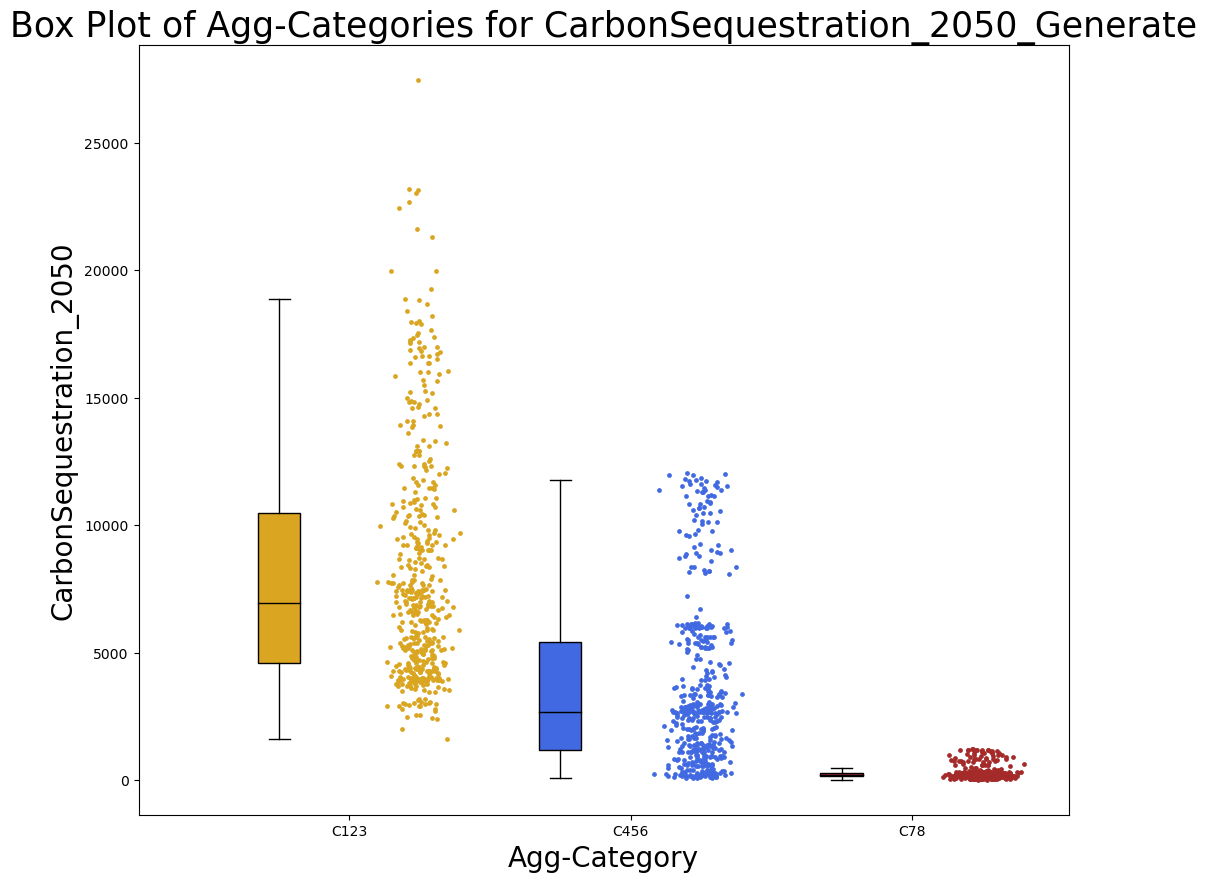

In [50]:
#CarbonSequestration_2050
import matplotlib.pyplot as plt
import seaborn as sns
Category_names = ['C123','C456','C78']
Data_Values = [Gen_C123[:,3,0],Gen_C456[:,3,0],Gen_C78[:,3,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for CarbonSequestration_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,30000])
#plt.savefig('Box Plot of Agg-Categories for CarbonSequestration_2050_Generate.pdf',format='pdf')
plt.show()

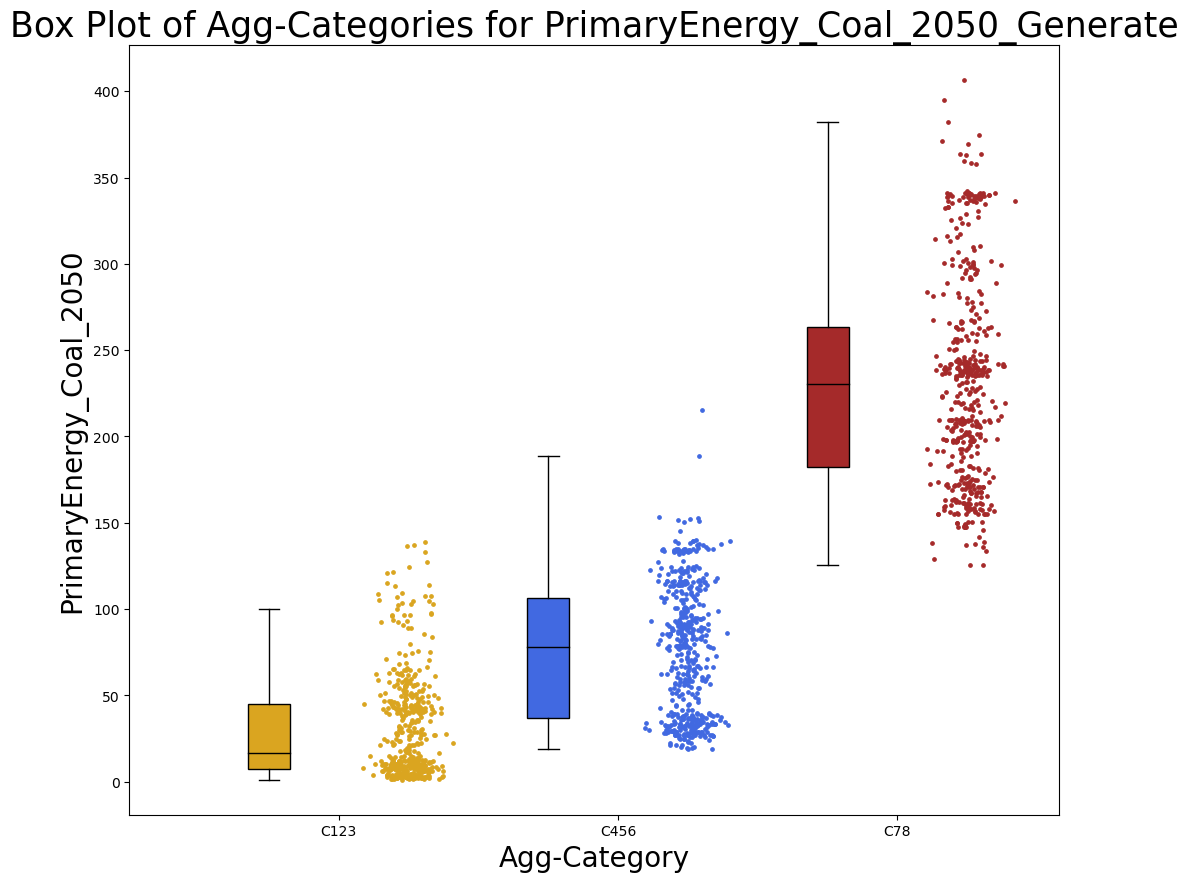

In [51]:
Data_Values = [Gen_C123[:,3,2],Gen_C456[:,3,2],Gen_C78[:,3,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,380])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2050_Generate.pdf',format='pdf')
plt.show()

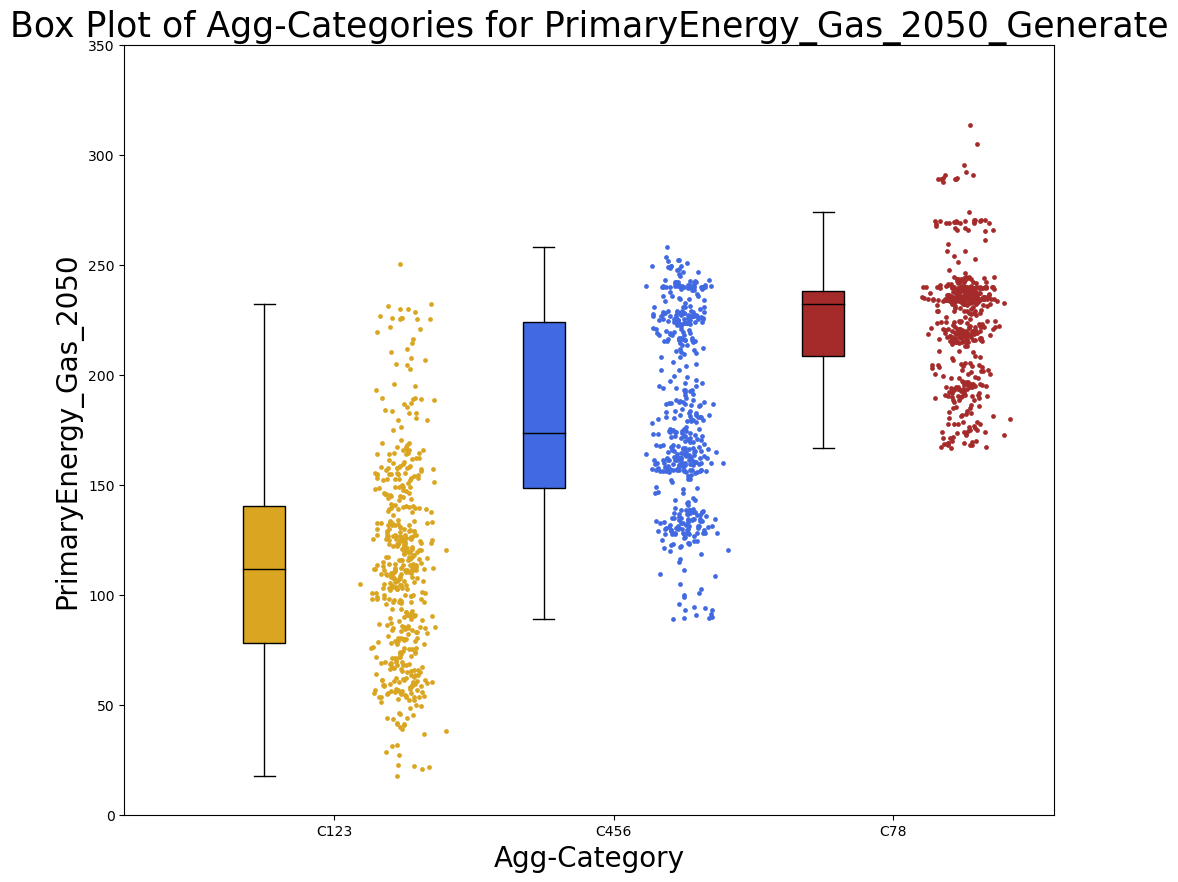

In [53]:
Data_Values = [Gen_C123[:,3,3],Gen_C456[:,3,3],Gen_C78[:,3,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2050_Generate.pdf',format='pdf')
plt.show()

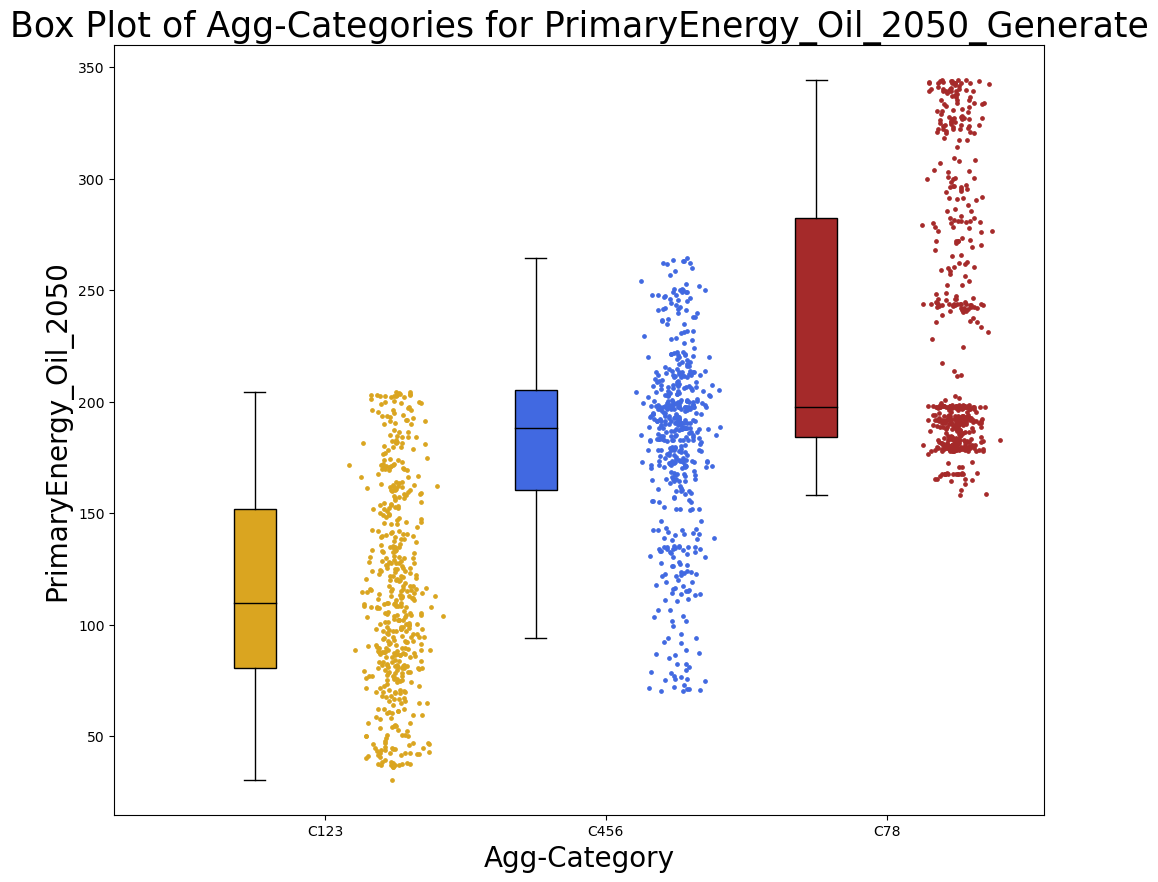

In [56]:
Data_Values = [Gen_C123[:,3,4],Gen_C456[:,3,4],Gen_C78[:,3,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2050_Generate.pdf',format='pdf')
plt.show()

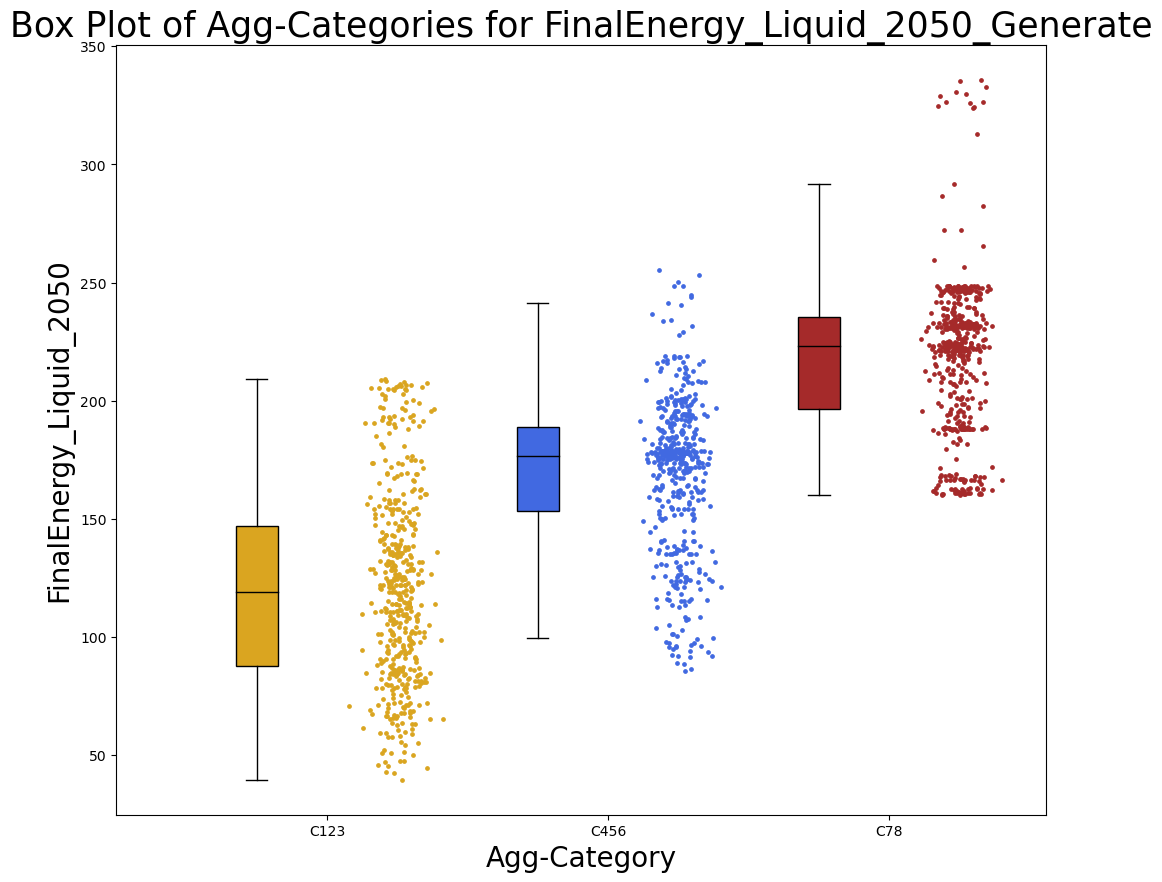

In [57]:
Data_Values = [Gen_C123[:,3,1],Gen_C456[:,3,1],Gen_C78[:,3,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for FinalEnergy_Liquid_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2050_Generate.pdf',format='pdf')
plt.show()

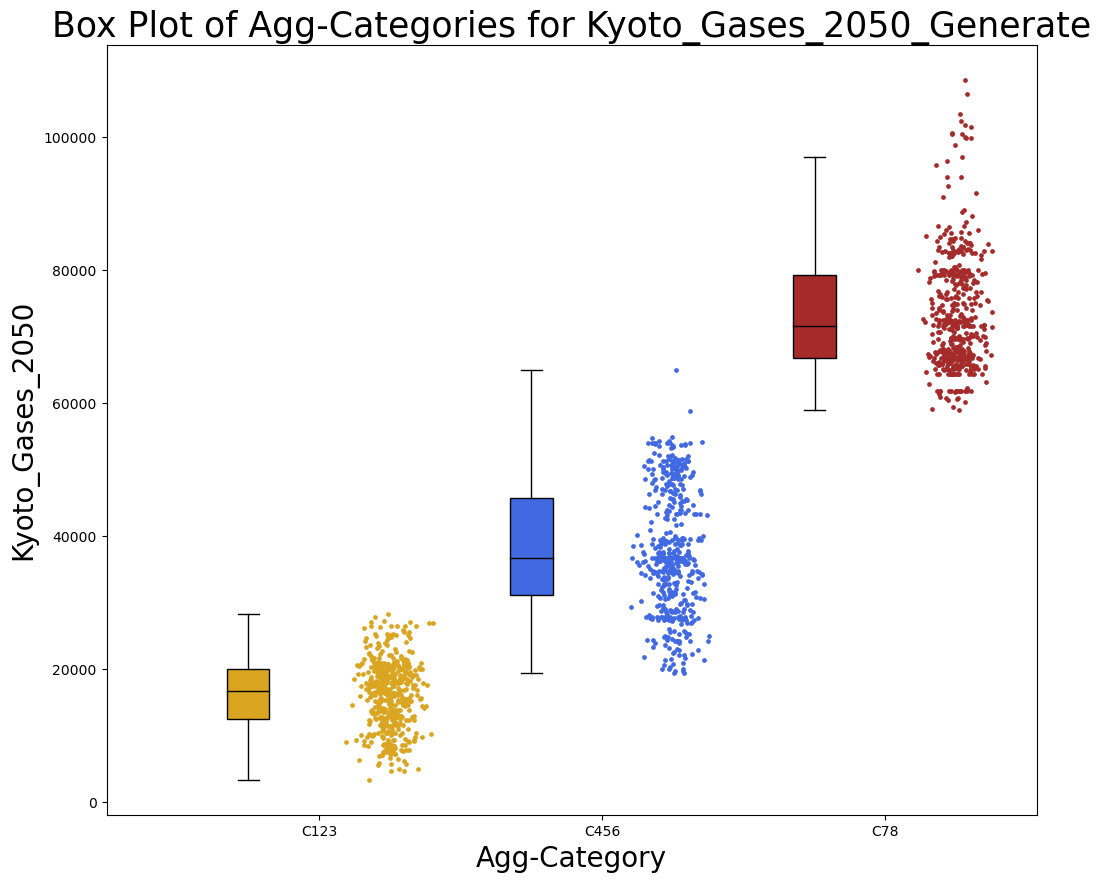

In [58]:
Data_Values = [Gen_C123[:,3,5],Gen_C456[:,3,5],Gen_C78[:,3,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for Kyoto_Gases_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2050_Generate.pdf',format='pdf')
plt.show()

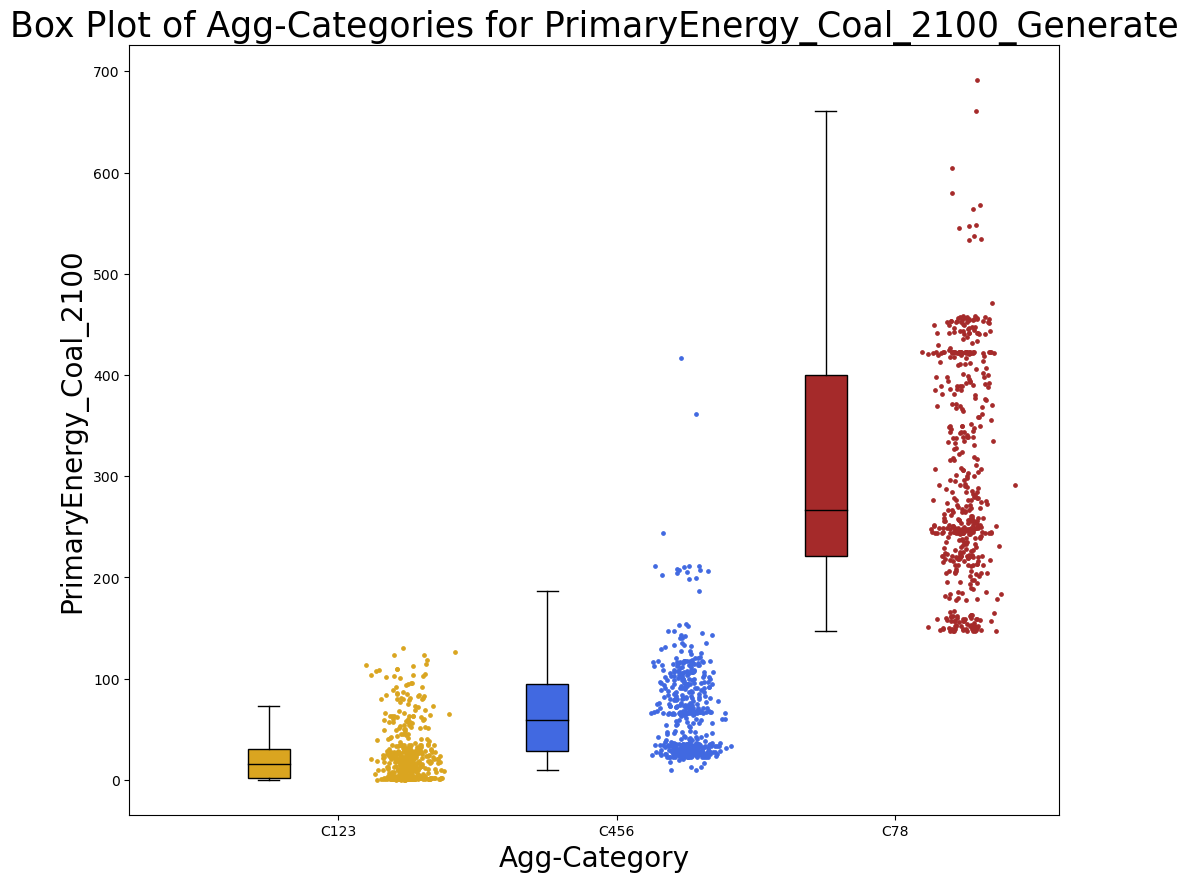

In [43]:
#PrimaryEnergy_Coal_2100
Data_Values = [Gen_C123[:,8,2],Gen_C456[:,8,2],Gen_C78[:,8,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,780])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2100_Generate.pdf',format='pdf')
plt.show()

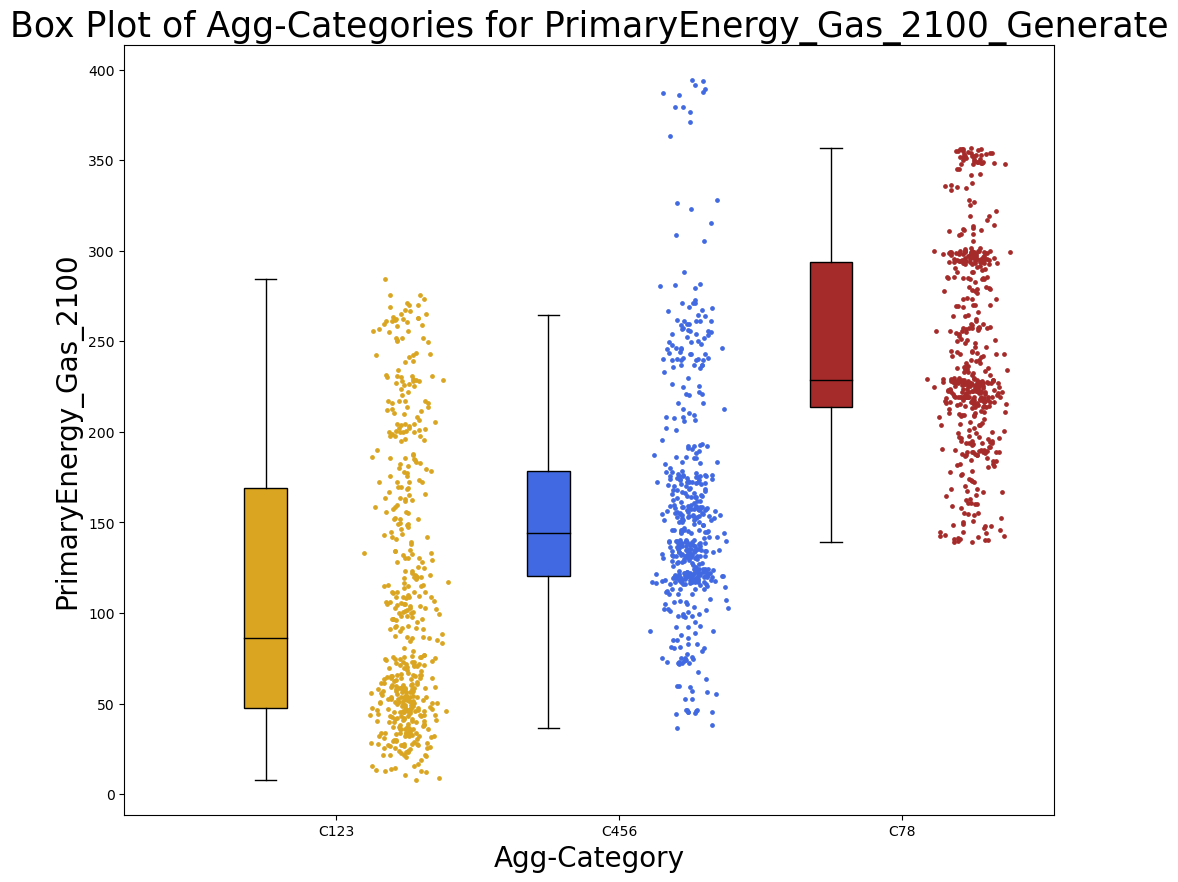

In [45]:
#PrimaryEnergy_Gas_2100
Data_Values = [Gen_C123[:,8,3],Gen_C456[:,8,3],Gen_C78[:,8,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,380])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2100_Generate.pdf',format='pdf')
plt.show()

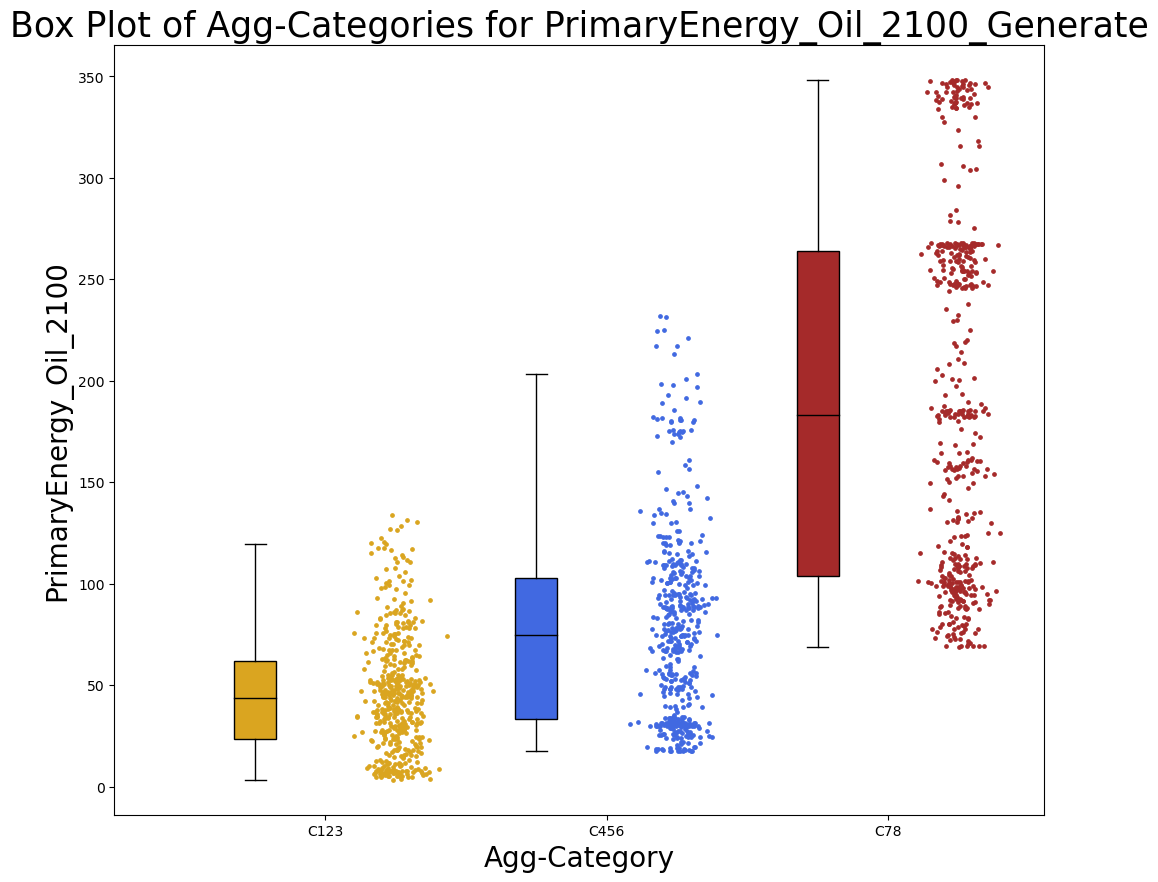

In [46]:
#PrimaryEnergy_Oil_2100
Data_Values = [Gen_C123[:,8,4],Gen_C456[:,8,4],Gen_C78[:,8,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,300])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2100_Generate.pdf',format='pdf')
plt.show()

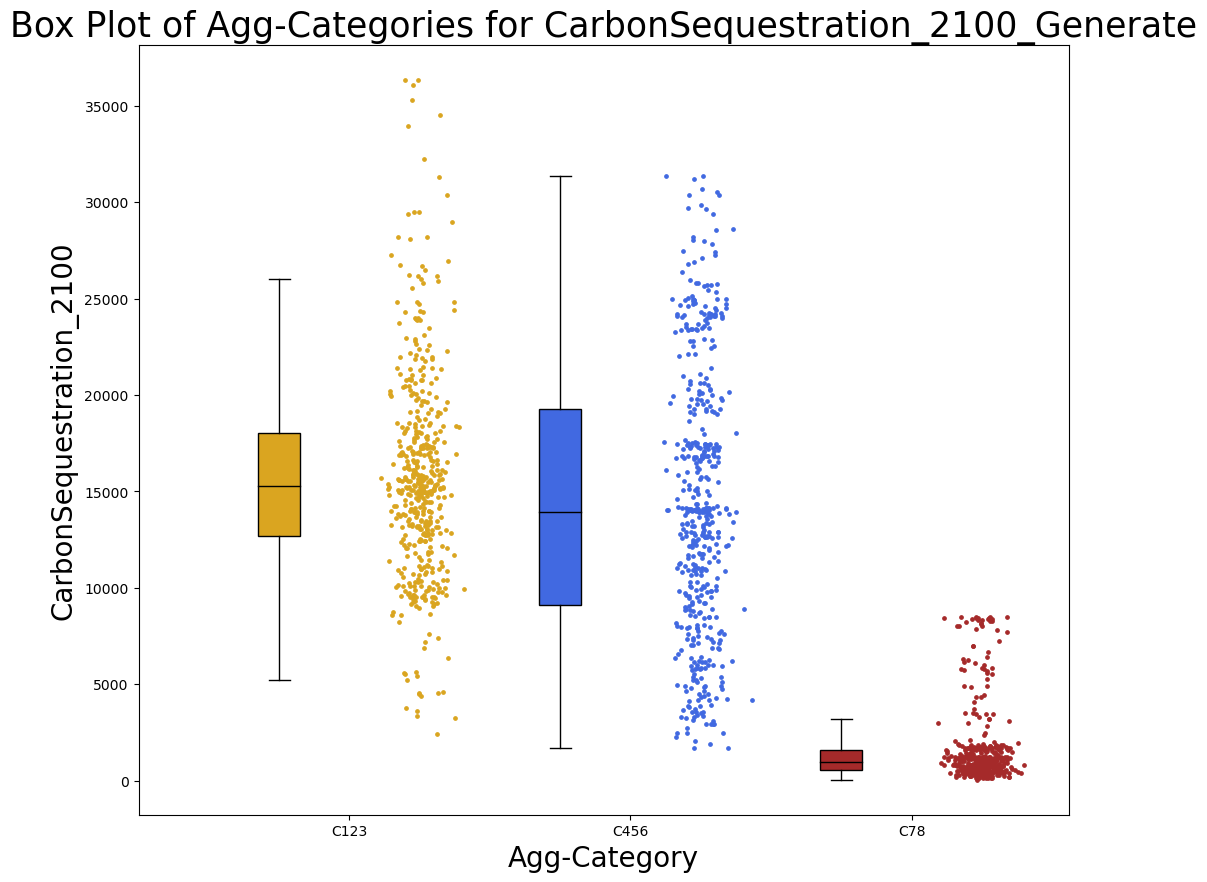

In [47]:
#CarbonSequestration_2100
Data_Values = [Gen_C123[:,8,0],Gen_C456[:,8,0],Gen_C78[:,8,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for CarbonSequestration_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,40000])
#plt.savefig('Box Plot of Agg-Categories for CarbonSequestration_2100_Generate.pdf',format='pdf')
plt.show()

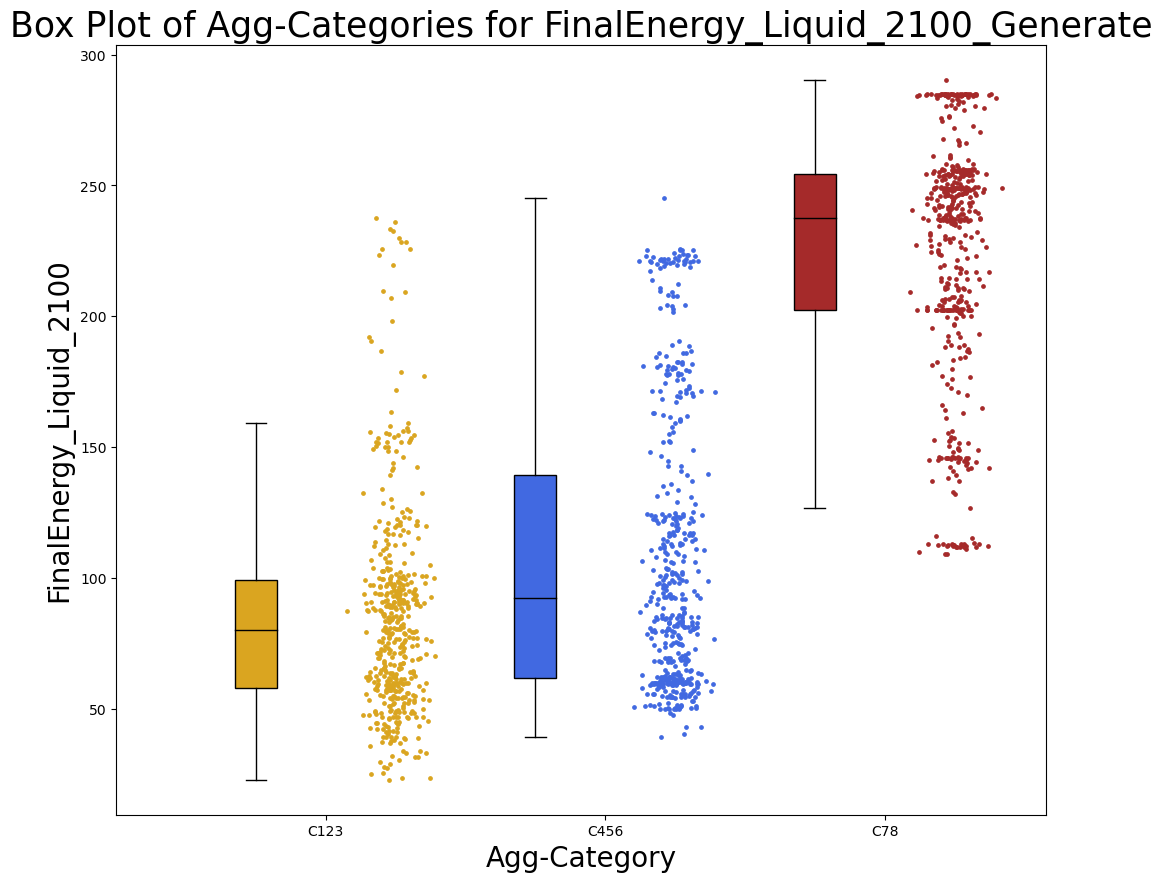

In [48]:
#FinalEnergy_Liquid_2100
Data_Values = [Gen_C123[:,8,1],Gen_C456[:,8,1],Gen_C78[:,8,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for FinalEnergy_Liquid_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,380])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2100_Generate.pdf',format='pdf')
plt.show()

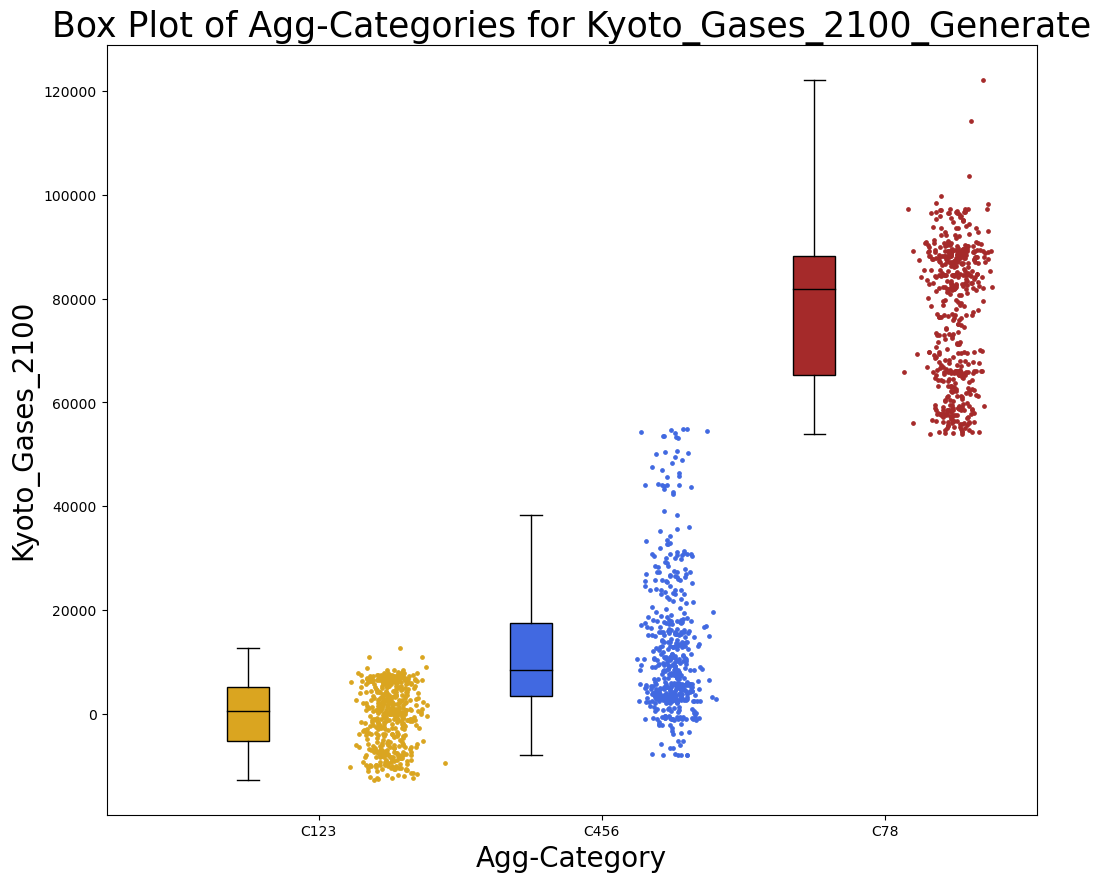

In [49]:
#Kyoto_Gases_2100
Data_Values = [Gen_C123[:,8,5],Gen_C456[:,8,5],Gen_C78[:,8,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for Kyoto_Gases_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
#plt.ylim([0,380])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2100_Generate.pdf',format='pdf')
plt.show()

In [59]:
#encoder1.save_weights('encoder1_weights.h5')
#encoder2.save_weights('encoder2_weights.h5')
#encoder3.save_weights('encoder3_weights.h5')
#decoder1.save_weights('decoder1_weights.h5')
#decoder2.save_weights('decoder2_weights.h5')
#decoder3.save_weights('decoder3_weights.h5')